In [4]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
import numpy as np
import clip
import json 
import time
import math

import random
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tokenizers import Tokenizer
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2, 5"


In [5]:
train_dir = "/data/dlcv/hw3/hw3_data/p2_data/images/train"
valid_dir = "/data/dlcv/hw3/hw3_data/p2_data/images/val"
train_json_dir = "/data/dlcv/hw3/hw3_data/p2_data/train.json"
val_json_dir = "/data/dlcv/hw3/hw3_data/p2_data/val.json"
ckpt_dir = "./p2"
tokenizer = Tokenizer.from_file("caption_tokenizer.json")
# device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.cuda.set_device(2)

print('Device used:', device)

Device used: cuda


In [19]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
with open(train_json_dir, 'r') as j:
    caption_json = json.loads(j.read())
# print(caption_json["images"][i].values() for i in range(10))
print(type(caption_json["images"][0]))
# print(type([0]*80))

<class 'dict'>


In [10]:
class p2dataset(Dataset):
    def __init__(self, inputPath, json_dir, transform=None):
        self.inputPath = inputPath
        self.transform = transform
        self.inputName = sorted(os.listdir(inputPath))
        with open(json_dir, 'r') as j:
            caption_json = json.loads(j.read())
        self.caption_json = caption_json
        self.filecap = {}
        for dic in self.caption_json["images"]:
            self.filecap[dic['id']] = {"filename" : dic["file_name"], "captions": []}
        for dic in self.caption_json["annotations"]:
            self.filecap[dic['image_id']]['captions'].append(dic['caption'])
        self.files = [dic for dic in self.filecap.values()]
        
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.inputPath, self.files[index]['filename']))
        if self.transform:
            img = self.transform(img)
        
        cap = self.files[index]['captions'][random.randint(0, len(self.files[index]['captions'])-1)]
        tokenized_caption = tokenizer.enable_padding(length=70)
        tokenized_caption = tokenizer.encode(cap)
        cut_eos = tokenized_caption.ids
        cut_eos[cut_eos.index(3)] = 0
        
        # [# of str, str len]
        return img, torch.Tensor(tokenized_caption.ids).long(), torch.Tensor(cut_eos).long()

    def __len__(self):
        return len(self.inputName)


In [11]:
_, preprocess = clip.load("ViT-L/14@336px", device)

In [25]:
train_dataset = p2dataset(train_dir, train_json_dir, transform=preprocess)
test_dataset = p2dataset(valid_dir, val_json_dir, transform=preprocess)
print('# images in train:', len(train_dataset))
print('# images in valid:', len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=1)

dataiter = iter(test_loader)
images, ids, cut_eos = dataiter.next()
print(images.shape)
print(ids[0])
print(cut_eos[0])
# print(filename)
# def imshow(img):
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
# # show images
# imshow(torchvision.utils.make_grid(images))


# images in train: 10604
# images in valid: 1789
torch.Size([256, 3, 336, 336])
tensor([   2,   32,  491,  217,  169, 1616,   32,  705,  118, 1428,   13,    3,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0])
tensor([   2,   32,  491,  217,  169, 1616,   32,  705,  118, 1428,   13,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  

### Model

In [12]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.clip_encoder, __ = clip.load('ViT-L/14@336px', device)
        self.clip_encoder = self.clip_encoder.float()
        #override vit's forward
        vit = self.clip_encoder.visual
        bound_method = vit_forward.__get__(vit, vit.__class__)
        setattr(vit, 'forward', bound_method)
        #Freeze model parameters
        for param in self.clip_encoder.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        return self.clip_encoder.encode_image(x)

def vit_forward(self, x):
    x = self.conv1(x)  # shape = [*, width, grid, grid]
    x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
    x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
    x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
    x = x + self.positional_embedding.to(x.dtype)
    x = self.ln_pre(x)

    x = x.permute(1, 0, 2)  # NLD -> LND
    x = self.transformer(x)
    x = x.permute(1, 0, 2)  # LND -> NLD

    x = self.ln_post(x[:,1:,:])
    if self.proj is not None:
            x = x @ self.proj
            
    return x   


class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x
    
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        # print("query = [batch size, query len, hid dim]:", query.shape)
        # print("key = [batch size, key len, hid dim]:", key.shape)
        # print("value = [batch size, value len, hid dim]", value.shape)
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        # print("Q = [batch size, query len, hid dim]:", Q.shape)
        # print("K = [batch size, key len, hid dim]:", K.shape)
        # print("V = [batch size, value len, hid dim]", V.shape)
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # print("Q = [batch size, n heads, query len, head dim]:", Q.shape)
        # print("K = [batch size, n heads, key len, head dim]:", K.shape)
        # print("V = [batch size, n heads, value len, head dim]", V.shape)
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        # print("energy = [batch size, n heads, query len, key len]: ", energy.shape)
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
        # print("attention = [batch size, n heads, query len, key len]: ", attention.shape)      
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        # print("x = [batch size, n heads, query len, key len]: ", x.shape)
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        # print("x = [batch size, n heads, query len, key len]: ", x.shape)    
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        # print("x = [batch size, n heads, query len, key len]: ", x.shape)            
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        # print("x = [batch size, n heads, query len, key len]: ", x.shape)                    
        #x = [batch size, query len, hid dim]
        
        return x, attention

class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask=None):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        # print("Start self attention.....")
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        # print("trg = [batch size, trg len, hid dim]:", trg.shape)    
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        # print("Start encoder attention.....")
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        # print("trg = [batch size, trg len, hid dim]:", trg.shape)            
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        # print("trg = [batch size, trg len, hid dim]:", trg.shape)
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention
    
    
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        self._reset_parameters()
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask=None):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # print("pos = [batch size, trg len]:", pos.shape)       
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        # print("trg = [batch size, trg len, hid dim]:", trg.shape)
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        # print("trg = [batch size, trg len, hid dim]: ", trg.shape)
        # print("attention = [batch size, n heads, trg len, src len]: ", attention.shape)
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        # print("output = [batch size, trg len, output dim]:", output.shape)
        #output = [batch size, trg len, output dim]
            
        return output, attention
    
    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
class Transformer(nn.Module):
    def __init__(self,  
                 decoder,  
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.decoder = decoder
        self.trg_pad_idx = trg_pad_idx
        self.device = device
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        # print("trg_pad_mask = [batch size, 1, 1, trg len]:", trg_pad_mask.shape)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len))).bool().to(device)
        # print("trg_sub_mask = [trg len, trg len]: ",trg_sub_mask.shape)
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        # print("trg_mask = [batch size, 1, trg len, trg len]:", trg_mask.shape)

        return trg_mask

    def forward(self, img, enc_src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
        src_mask = torch.ones((img.shape[0],1,1,1)).bool().to(device)
        # print("src_mask = [batch size, 1, 1, src len]:", src_mask.shape)
        
        trg_mask = self.make_trg_mask(trg)
        # print("trg_mask = [batch size, 1, trg len, trg len]:", trg_mask.shape)
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        # enc_src = self.encoder(img)#.unsqueeze(1).float()
        # print("enc_src = [batch size, src len, hid dim]: ", enc_src.shape)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        # print("output = [batch size, trg len, output dim]:", output.shape)
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_loss(pred, ans, vocab_size=18022, label_smoothing=0.01, pad=0):
    # took this "normalizing" from tensor2tensor. We subtract it for
    # readability. This makes no difference on learning.
    confidence = 1.0 - label_smoothing
    low_confidence = (1.0 - confidence) / float(vocab_size - 1)
    normalizing = -(
        confidence * math.log(confidence) + float(vocab_size - 1) *
        low_confidence * math.log(low_confidence + 1e-20))

    one_hot = torch.zeros_like(pred).scatter_(1, ans.unsqueeze(1), 1)
    one_hot = one_hot * confidence + (1 - one_hot) * low_confidence
    log_pred = F.log_softmax(pred, dim=1)
    #print("=========test2=========", log_pred)

    xent = -(one_hot * log_pred).sum(dim=1)
    xent = xent.masked_select(ans != pad)
    loss = (xent - normalizing).mean()
    return loss

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train(model, enc, train_loader, optimizer, scheduler, criterion, clip):
    
    model.train()
    enc = enc.to(device)

    epoch_loss = 0
    criterion = get_loss
    for i ,(img, trg, trg_cut) in enumerate(train_loader):
        
        img, trg, trg_cut = img.to(device), trg.to(device), trg_cut.to(device)
        with torch.no_grad():
            enc_src = enc(img)
        output, attention = model(img, enc_src, trg_cut)
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        # print("output ", output.shape)
        # trg = trg.contiguous().view(-1)
        ans = torch.roll(trg, -1)
        ans[:, -1] = 0
        ans = ans.view(-1)
        # print("ans ", ans.shape) 
                        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        # loss = criterion(output, ans)
        loss = get_loss(output, ans)
        epoch_loss += loss.item()   
        # print(f'| train Loss: {loss:.3f}')
        optimizer.zero_grad()               
        loss.backward()
        optimizer.step()
    # scheduler.step()
             
    return epoch_loss / (i+1)

def evaluate(model, enc, test_loader, criterion):
    
    model.eval()
    enc = enc.to(device)
    epoch_loss = 0
    criterion = get_loss    
    for i, (img, trg, trg_cut) in enumerate(test_loader):
        img, trg, trg_cut = img.to(device), trg.to(device), trg_cut.to(device)
        # output, _ = model(img, trg)
        
        with torch.no_grad():
            enc_src = enc(img)
            # output, _ = model(img, trg[:,:-1])
            output, attention = model(img, enc_src, trg_cut)
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            # trg = trg.contiguous().view(-1)
            ans = torch.roll(trg, -1)
            ans[:, -1] = 0
            ans = ans.view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            # loss = criterion(output, ans)
            loss = get_loss(output, ans)
            # print(f'| val Loss: {loss:.3f}')            
            epoch_loss += loss.item()
        
    return epoch_loss / (i+1)

In [13]:
OUTPUT_DIM = 18022
HID_DIM = 768
ENC_LAYERS = 3
DEC_LAYERS = 6
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
TRG_PAD_IDX = 0
LEARNING_RATE = 1e-4
PAD = 0
BOS = 2
EOS = 3

# enc, _ = clip.load('ViT-L/14@336px')

enc = Encoder()

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)
model = Transformer(dec, TRG_PAD_IDX, device).to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')
# model = model.apply(initialize_weights)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[12,15], gamma=0.3)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX, label_smoothing=0.1)

The model has 60,878,950 trainable parameters


In [68]:
N_EPOCHS = 30
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, enc, train_loader, optimizer, criterion, scheduler, CLIP)
    scheduler.step()
    valid_loss = evaluate(model, enc, test_loader, criterion)

    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(ckpt_dir, 'ViTLlayer6_test.pt'))
        print(f"|save model for {epoch+1}")
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

|save model for 0
Epoch: 01 | Time: 6m 40s
	Train Loss: 4.934 | Train PPL: 138.893
	 Val. Loss: 4.123 |  Val. PPL:  61.751
|save model for 1
Epoch: 02 | Time: 6m 40s
	Train Loss: 3.864 | Train PPL:  47.632
	 Val. Loss: 3.616 |  Val. PPL:  37.180
|save model for 2
Epoch: 03 | Time: 7m 37s
	Train Loss: 3.466 | Train PPL:  32.007
	 Val. Loss: 3.314 |  Val. PPL:  27.483
|save model for 3
Epoch: 04 | Time: 14m 5s
	Train Loss: 3.208 | Train PPL:  24.718
	 Val. Loss: 3.171 |  Val. PPL:  23.828
|save model for 4
Epoch: 05 | Time: 14m 10s
	Train Loss: 3.036 | Train PPL:  20.831
	 Val. Loss: 3.030 |  Val. PPL:  20.705
|save model for 5
Epoch: 06 | Time: 9m 38s
	Train Loss: 2.927 | Train PPL:  18.671
	 Val. Loss: 2.921 |  Val. PPL:  18.561
|save model for 6
Epoch: 07 | Time: 6m 41s
	Train Loss: 2.803 | Train PPL:  16.489
	 Val. Loss: 2.879 |  Val. PPL:  17.792
|save model for 7
Epoch: 08 | Time: 6m 40s
	Train Loss: 2.741 | Train PPL:  15.508
	 Val. Loss: 2.807 |  Val. PPL:  16.558
|save model for

In [15]:
class valdataset(Dataset):
    def __init__(self, inputPath,  transform=None):
        self.inputPath = inputPath
        self.transform = transform
        self.inputName = sorted(os.listdir(inputPath))        
        
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.inputPath, self.inputName[index]))
        if self.transform:
            img = self.transform(img)
        
        return img, self.inputName[index].replace(".jpg", "")

    def __len__(self):
        return len(self.inputName)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
# show images

In [14]:
inference_dataset = valdataset(valid_dir, transform=preprocess)
print('# images in valid:', len(inference_dataset))

inference_loader = DataLoader(inference_dataset, batch_size=1, shuffle=False, num_workers=0)

dataiter = iter(inference_loader)
images,  filename = dataiter.next()
print(filename[0])
# imshow(torchvision.utils.make_grid(images))

# images in valid: 1789
000000000368


In [15]:
def inference(enc, testmodel, inference_loader):
    pred = {}
    BOS = 2
    EOS = 3
    max_len = 77
    testmodel.eval()
    
    for i, (img, filename) in enumerate(inference_loader):
        img = img.to(device)
        batch_size = img.shape[0]
        
        trg_indexes = torch.zeros((batch_size, max_len), dtype=torch.int32)
        trg_indexes[:, 0] = BOS
        # print(trg_indexes)
        trg_indexes = trg_indexes.to(device)
        
        with torch.no_grad():
            enc_src = enc(img).float().to(device)
                               
            for index in range(1, max_len):
                # trg_mask = testmodel.make_trg_mask(trg_indexes)
                # out, attention = testmodel.decoder(trg_indexes, enc_src, trg_mask)
                out, attention = testmodel(img, enc_src, trg_indexes)
                
                pred_token = out.argmax(2)[:,-1].item()
                # print("pred: ",pred_token)
                trg_indexes[:,index] = pred_token
                # print(pred_token[:,index])
                if pred_token == EOS:
                    break
                # print("trg: ", trg_indexes)
            trg_indexes = trg_indexes.cpu().numpy().squeeze().tolist()
        caption = tokenizer.decode(trg_indexes)
        print(caption)
        pred[filename[0]] = caption
    return pred    

def inference2(enc, testmodel, inference_loader):
    dict = {}
    testmodel.eval()
    max_len = 60
    with torch.no_grad():
        for img, filename in inference_loader:
            img = img.to(device)
            trg_indexes = [BOS]
            hasEOS = False
            with torch.no_grad():
                enc_src = enc(img).float().to(device)
                
                for i in range(max_len):
                    trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
                    out, attention = testmodel(img, enc_src, trg_tensor)
                    
                    pred_token = out.argmax(2)[:,-1].item()
                    trg_indexes.append(pred_token)
                    if(pred_token == EOS):
                        hasEOS = True
                        break
            if hasEOS:
                caption = tokenizer.decode(trg_indexes[:trg_indexes.index(EOS)])
            else:
                caption = tokenizer.decode(trg_indexes[:max_len])
            # print(caption)
            dict[filename[0]] = caption
    return dict

In [16]:
# load model
enc = Encoder()

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)
testmodel = Transformer(dec, TRG_PAD_IDX, device).to(device)

print(f'The model has {count_parameters(testmodel):,} trainable parameters')
# model = model.apply(initialize_weights)
# optimizer = torch.optim.Adam(testmodel.parameters(), lr = LEARNING_RATE)
# criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX, label_smoothing=0.05)
testmodel.load_state_dict(torch.load(os.path.join(ckpt_dir, 'ViTLlayer6.pt')))

The model has 60,878,950 trainable parameters


<All keys matched successfully>

In [17]:
output = inference2(enc, testmodel, inference_loader)
with open("./p2/output.json", "w") as f:
    json.dump(output, f, indent=4)

In [18]:
# learning rate 1e-4, layer4
!python3 p2_evaluate.py --pred_file "./p2/output.json" --images_root "/data/dlcv/hw3/hw3_data/p2_data/images/val"  --annotation_file "/data/dlcv/hw3/hw3_data/p2_data/val.json"

/home/jhccc/anaconda3/envs/dlcv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
PTBTokenizer tokenized 110968 tokens at 733227.53 tokens per second.
PTBTokenizer tokenized 22378 tokens at 179029.57 tokens per second.
CIDEr: 0.8750356996336179 | CLIPScore: 0.7062281037656337


In [6]:
class CLIPScore:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load("ViT-B/32", device=self.device)
        self.model.eval()

    def __call__(self, predictions, images_root):
        """
        Input:
            predictions: dict of str
            images_root: str
        Return:
            clip_score: float
        """
        total_score = 0.
        max_score, min_score = 0.0, 100.0
        max_path, min_path = "", ""
        for img_name, pred_caption in predictions.items():
            image_path = os.path.join(images_root, f"{img_name}.jpg")
            image = Image.open(image_path).convert("RGB")
            score = self.getCLIPScore(image, pred_caption)
            if score > max_score:
                max_score = score
                max_path = image_path
            if score < min_score:
                min_score = score
                min_path = image_path
            total_score += score
        max = [max_score, max_path]
        min = [min_score, min_path]
        return total_score / len(predictions), max, min

    def getCLIPScore(self, image, caption):
        """
        This function computes CLIPScore based on the pseudocode in the slides.
        Input:
            image: PIL.Image
            caption: str
        Return:
            cilp_score: float
        """
        image_input = self.preprocess(image).unsqueeze(0).to(self.device)
        text_input = clip.tokenize([caption]).to(self.device)

        with torch.no_grad():
            image_features = self.model.encode_image(image_input)
            text_features = self.model.encode_text(text_input)
        
        cos_sim = torch.nn.functional.cosine_similarity(image_features, text_features).item()
        return 2.5 * max(cos_sim, 0)

def readJSON(file_path):
    try:
        with open(file_path) as f:
            data = json.load(f)
        return data
    except:
        return None

In [7]:
predictions = readJSON("./p2/pred.json")
clip_score, max, min = CLIPScore()(predictions, valid_dir)
print(clip_score, max, min)


0.7197610888153297 [0.9765625, '/data/dlcv/hw3/hw3_data/p2_data/images/val/000000179758.jpg'] [0.37322998046875, '/data/dlcv/hw3/hw3_data/p2_data/images/val/3686612004.jpg']


In [12]:
predictions[max[1].split("/")[-1].replace(".jpg", "")]

'a woman holding a kite in a field .'

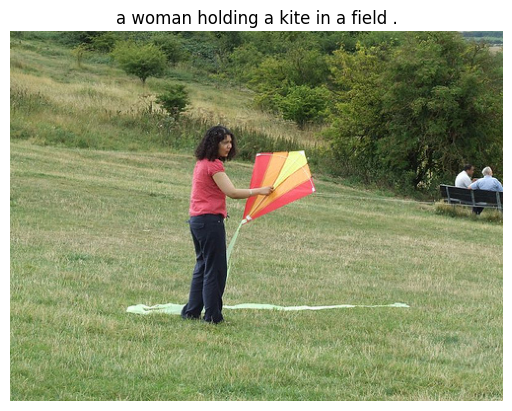

In [39]:
imagemax = Image.open(max[1]).convert("RGB")
imagemin = Image.open(min[1]).convert("RGB")
plt.title(predictions[max[1].split("/")[-1].replace(".jpg", "")])
plt.axis("off")
plt.imshow(np.asarray(imagemax))
# print(max[1])

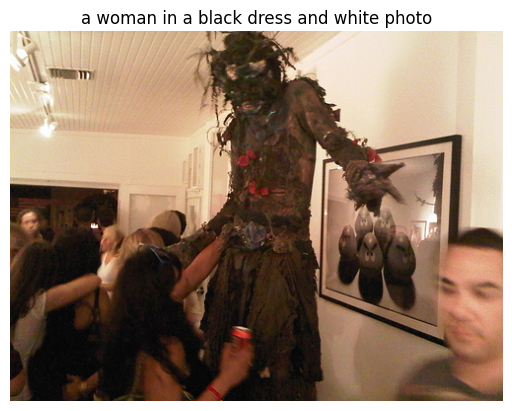

In [36]:
plt.title(predictions[min[1].split("/")[-1].replace(".jpg", "")])
plt.axis('off')
plt.imshow(np.asarray(imagemin))
